# Import libraries

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import collections
import re
import string
import matplotlib.pyplot as plt
from collections import defaultdict
from bs4 import BeautifulSoup

from gensim import models
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import initializers
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Layer, InputSpec, TextVectorization
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding, MaxPooling1D,GRU, Bidirectional
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras import Sequential
from keras.utils.vis_utils import plot_model
from __future__ import division, print_function

os.environ['KERAS_BACKEND']='theano'
plt.switch_backend('agg')
%matplotlib inline

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

nltk and gensim are two famous libraries that are used in Natural Language Processing (NLP). nltk library has been used to get the stop words of English language and to lemmatize words. Also gensim library has been used to load the Doc2vec model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
proj_dir='/content/drive/MyDrive/Colab Notebooks/doc2vec/' #give your project directory here. data sets should be in this location

# Load and clean the data

before converting into vectors text should be cleaned.

* Lower the english latters
* Remove headers
* Drop all digits
* Remove URLs and Emails
* Drop all punctuation from our text
* Drop stop words
* Lemmatize words


first, we convert all the letters into lowercase letters in order to avoid duplicating the same word ('Dog' and 'dog' are the same words. but the program will take these as two words. Hence we convert 'Dog' as 'dog' by doing letters lowercase)

After that we drop all the headers and numbers.Because headers are unwanted data and numbers don't have any meaning when we take them as a single word.

if any word contains '@','.com' or 'http' we drop those words. also we remove all punctuations and stop words. The words which are generally filtered out before processing a natural language are called stop words. These are actually the most common words such as “the”, “a”, “an”, “so”, “what” in English language. By removing these words, we remove the low-level information from our text in order to give more focus to the important information.

finally we lemmatize words. Lemmatization is the process wherein the context is used to convert a word to its meaningful base or root form. ex:- driving--> drive , dogs-->dog. To perform Lemmatization with Natural Language Tool Kit (NLTK), “WordNetLemmatizer()” method has been used

In [4]:
'''this function is used to read text files.'''
def read_txt_file(file_name):
    with open(file_name,encoding="utf8", errors='ignore') as f:
        ###extract the boady of the text###
        line = f.readline()
        txt=''
        txt=txt+' '+line
        while line:
            line = f.readline()
            txt=txt+' '+line
        ###################################
    f.close()
    return(txt)

In [5]:
stop_words=set(stopwords.words('english'))#load stop words
punctuations=string.punctuation #get punctuations
lemmatizer = WordNetLemmatizer()
'''this function is used to clean text'''
def clean_txt(txt):
    txt=txt.lower() #set all characters to lowercase
    sentences=txt.split('\n')
    txt = ' '.join([i for i in sentences if not ':' in i])#remove headers
    txt = ''.join([i for i in txt if not i.isdigit()])#remove numbers

    ###remove urls and emails###
    words=txt.split()
    txt = ' '.join([i for i in words if not '@' in i and not '.com' in i and not  'http:' in i])
    #######################################

    ###remove punctuations###
    for character in punctuations:
        txt = txt.replace(character, '')
    #########################################
    
    ###remove stop words and lemmatize###
    words=txt.split()
    filtered_txt = ' '.join([lemmatizer.lemmatize(i) for i in words if not i in stop_words])
    #####################################
    
    return(filtered_txt)

In [6]:
def load_and_clean_data(location):    
    y=os.listdir(location)#get the list of folder
    txts=[]
    txts_cleaned=[]
    folder_array=[]
    file_array=[]
    for i in range(len(y)):
        text_file_names=os.listdir(location+'/'+y[i]) #get the list of files
        for text_file_name in text_file_names:
                file_array.append(text_file_name)
                txt=read_txt_file(location+'/'+y[i]+'/'+text_file_name) #read the text file
                txts.append(txt)
                txts_cleaned.append(clean_txt(txt)) #clean the text
                folder_array.append(y[i])

    ###create a data frame###
    df=pd.DataFrame()
    df['texts']=txts
    df['text cleaned']=txts_cleaned
    df['folder name']=folder_array
    df['file name']=file_array
    ########################
    return (df)



In [7]:
df_train=load_and_clean_data(proj_dir+'20news-bydate-train')
df_test=load_and_clean_data(proj_dir+'20news-bydate-test')

In [8]:
df_train.head()

,texts,text cleaned,folder name,file name
0,From: hudson@athena.cs.uga.edu (Paul Hudson J...,sin violate sunday one could ever forgiven jes...,talk.religion.misc,83670
1,From: decay@cbnewsj.cb.att.com (dean.kaflowit...,snide think christianity must convenient relig...,talk.religion.misc,82804
2,From: sandvik@newton.apple.com (Kent Sandvik)...,article tional many one direct benefit able ke...,talk.religion.misc,83846
3,From: alamut@netcom.com (Max Delysid (y!))\n ...,name three really competing rosicrucian order ...,talk.religion.misc,83501
4,From: ad354@Freenet.carleton.ca (James Owens)...,un resolution guarantee humanitarian aid get i...,talk.religion.misc,82807


In [9]:
df_test.head()

,texts,text cleaned,folder name,file name
0,From: bskendig@netcom.com (Brian Kendig)\n Su...,dont get oncoming truck lose look look certain...,talk.religion.misc,84192
1,From: livesey@solntze.wpd.sgi.com (Jon Livese...,well im claiming moral system absolute jon lis...,talk.religion.misc,84194
2,From: markbr%radian@natinst.com (mark)\n Subj...,sunlight shining ocean universe mirrored puddl...,talk.religion.misc,84292
3,From: livesey@solntze.wpd.sgi.com (Jon Livese...,quite different saying employing force people ...,talk.religion.misc,84193
4,From: ddavis@cass.ma02.bull.com (Dave Davis)\...,russell turpin wont raised interesting issue s...,talk.religion.misc,84252


In [10]:
#save clean data sets before vectorize it 
df_train.to_csv(proj_dir+'cleaned_train_data.csv')
df_test.to_csv(proj_dir+'cleaned_test_data.csv')

# Convert to vectors

document is tokenized into words and applied doc2vec model. doc2vec is a method to represent list of words using a vector. it is used to create a vectorised representation of a group of words taken collectively as a single unit.In gensim the model will always be trained on a word per word basis. Therefore  we split the document into an array of words using split(). In order to train the model, tagged documents are needed. it can be created by using models.doc2vec.TaggedDcument(). then finally we train the doc2vec model

In [11]:
'''this function is used to do tokenization'''
def tokenizer(txt):  
    tokens=txt.split(' ')
    unique_tokens=np.unique(np.array(tokens)) #get unique tokens
    ###create a dictonary of tokens###
    tokens_dict={}
    for indx in range(len(unique_tokens)):
        tokens_dict[unique_tokens[indx]]=indx
    return(tokens_dict,tokens)

In [12]:
#tokanize train and test data
words_list=[]
for i in range(len(df_train)):
    _,words=tokenizer(df_train['text cleaned'][i]) 
    words_list.append(words)
for i in range(len(df_test)):
    _,words=tokenizer(df_test['text cleaned'][i])
    words_list.append(words)
####################################

In [13]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(words_list)]
model = Doc2Vec(vector_size=40, min_count=2, epochs=30) #fit the Doc2Vec model
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

In [14]:
###get train vectors##
train_vectors=[]
for i in range(len(df_train)):
    train_vectors.append(model.infer_vector(list(df_train['text cleaned'][i].split(' '))))
##########################

In [15]:
##get test vectors##
test_vectors=[]
for i in range(len(df_test)):
    test_vectors.append(model.infer_vector(list(df_test['text cleaned'][i].split(' '))))
############################

In [16]:
train=pd.DataFrame(train_vectors)
train['folder name']=df_train['folder name']
train['file name']=df_train['file name']
test=pd.DataFrame(test_vectors)
test['folder name']=df_test['folder name']
test['file name']=df_test['file name']

In [17]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,folder name,file name
0,0.028640,-0.275794,1.936172,0.944144,1.591527,-1.578293,-1.432226,-0.183980,0.979865,-0.761045,...,-0.412266,1.328759,-0.006485,0.170231,-0.596506,0.124186,-0.114431,-0.810567,talk.religion.misc,83670
1,1.932167,-0.007840,0.887217,2.449002,0.870332,-0.111808,-0.401761,0.487193,-0.862251,-0.065590,...,0.594137,-0.183385,1.646320,-0.907313,-0.944492,-0.203790,-1.277506,-1.723074,talk.religion.misc,82804
2,0.344415,0.161102,0.174821,1.055462,0.780058,-0.122243,-1.123141,1.437676,-0.470622,0.500672,...,-0.538999,-0.225427,0.111691,-1.366534,-0.644672,-0.396107,0.033322,-0.290731,talk.religion.misc,83846
3,0.158908,0.681517,-0.502381,1.503052,-0.054642,-0.368599,0.492085,-0.501714,-0.364845,0.380846,...,0.162273,0.436177,0.798319,-0.913327,-0.227527,-0.776683,0.305000,1.368573,talk.religion.misc,83501
4,0.199934,-0.136925,0.253297,1.212826,-0.011133,0.034876,-0.285469,-0.701532,-0.860310,-0.398424,...,1.217697,0.094914,0.560259,-0.392581,-0.349785,-0.573991,0.490768,0.689401,talk.religion.misc,82807


In [18]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,folder name,file name
0,-0.375486,1.058034,0.309208,2.247116,0.100208,-0.793853,-0.286488,-1.765128,0.417846,-0.102395,...,-0.478925,-0.601931,0.167600,-0.209433,1.079548,-1.644842,-0.429050,0.324622,talk.religion.misc,84192
1,0.533539,-0.232845,-0.774179,0.849714,0.965211,0.697540,0.156163,-0.034169,-0.838396,-0.019463,...,0.104406,-0.102596,-0.353494,-0.913645,0.853605,0.215714,0.672778,0.156009,talk.religion.misc,84194
2,0.924157,0.567572,-0.676007,0.733939,0.411435,-0.934025,-0.352718,-0.638176,-0.329521,-0.174292,...,0.289557,-0.283448,0.015847,-0.446191,-0.322382,0.508879,-0.271960,0.062092,talk.religion.misc,84292
3,2.647716,-0.056465,1.543842,2.954860,0.330396,-0.315831,1.796900,0.464359,0.725439,-1.608417,...,1.203880,1.130053,0.644527,-2.209796,-1.088789,-2.430511,-0.078845,0.815308,talk.religion.misc,84193
4,0.867726,-1.047523,1.768745,2.027673,-1.419906,-1.745944,0.561544,2.366570,-1.000797,0.707363,...,0.452357,1.491700,0.516546,-2.063554,-0.739530,-1.936160,2.127003,-0.072430,talk.religion.misc,84252


In [19]:
train_,validation=train_test_split( train, test_size=0.33, random_state=42) #split data into train and validation sets

In [20]:
len(train_),len(test),len(validation)

(7580, 7532, 3734)

In [21]:
#save data sets
train_.to_csv(proj_dir+'train_data.csv')
test.to_csv(proj_dir+'test_data.csv')
validation.to_csv(proj_dir+'validation_data.csv')

# Modeling

## Load data

In [22]:
#read data which was saved in the feature generation part
train=pd.read_csv(proj_dir+'train_data.csv')
test=pd.read_csv(proj_dir+'test_data.csv')
validation=pd.read_csv(proj_dir+'validation_data.csv')

## Data rearrange for modeling

In [23]:
#extract X and y data from data frames
X_train=train[[str(i) for i in range(40)]]
y_train=train['folder name']

X_test=test[[str(i) for i in range(40)]]
y_test=test['folder name']

X_validation=validation[[str(i) for i in range(40)]]
y_validation=validation['folder name']

In [24]:
names=np.unique(np.array(y_train)) #getting unique categories
print(names)

['alt.atheism' 'comp.graphics' 'comp.os.ms-windows.misc'
 'comp.sys.ibm.pc.hardware' 'comp.sys.mac.hardware' 'comp.windows.x'
 'misc.forsale' 'rec.autos' 'rec.motorcycles' 'rec.sport.baseball'
 'rec.sport.hockey' 'sci.crypt' 'sci.electronics' 'sci.med' 'sci.space'
 'soc.religion.christian' 'talk.politics.guns' 'talk.politics.mideast'
 'talk.politics.misc' 'talk.religion.misc']


In [25]:
# Category mapping
y_train_en=[np.where(names==name)[0] for name in y_train ]
y_test_en=[np.where(names==name)[0] for name in y_test ]
y_validation_en=[np.where(names==name)[0] for name in y_validation ]

In [26]:
# Category encoding
# keras.utils.to_categorical is a function used to Converts a class vector (integers) to binary class matrix
# so by the end of this code block we will have encoded categories so we are ready to use it in the model. 
y_train_en=keras.utils.to_categorical(y_train_en)
y_test_en=keras.utils.to_categorical(y_test_en)
y_validation_en=keras.utils.to_categorical(y_validation_en)

## Model

In [27]:
### building the model
classifier = Sequential() #The sequential API allows you to create models layer-by-layer for most problems.
classifier.add(Dense(units=100, input_dim=40, kernel_initializer='uniform', activation='relu'))# relu (Rectifier linear unit) function
classifier.add(Dense(units=80, kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(0.2)) # dropout layer to prevent overfitting
classifier.add(Dense(units=60, kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(0.2)) # dropout layer to prevent overfitting
classifier.add(Dense(units=30, kernel_initializer='uniform', activation='relu'))

####################### Output layer############################################
# sigmoid means sigmoid activation function
# for Multiclass classification the activation ='softmax'
classifier.add(Dense(units=20, kernel_initializer='uniform', activation='sigmoid'))
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 dense_1 (Dense)             (None, 80)                8080      
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 60)                4860      
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_3 (Dense)             (None, 30)                1830      
                                                                 
 dense_4 (Dense)             (None, 20)                6

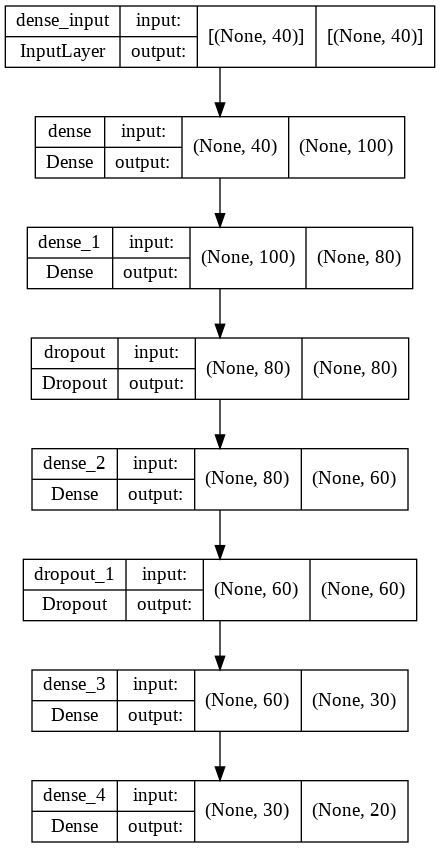

In [28]:
plot_model(classifier, to_file=proj_dir+'model_plot.png', show_shapes=True, show_layer_names=True) # plot and save the model diagramm

In [29]:
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #compile the model

# fitting the Neural Network on the training data
history=classifier.fit(X_train,y_train_en,validation_data=(X_validation, y_validation_en), batch_size=50 , epochs=40, verbose=1)

Epoch 1/40
152/152 [==============================] - 1s 4ms/step - loss: 0.3114 - accuracy: 0.0512 - val_loss: 0.2094 - val_accuracy: 0.0578
Epoch 2/40
152/152 [==============================] - 0s 3ms/step - loss: 0.2073 - accuracy: 0.0511 - val_loss: 0.2010 - val_accuracy: 0.0541
Epoch 3/40
152/152 [==============================] - 0s 3ms/step - loss: 0.2013 - accuracy: 0.0573 - val_loss: 0.1990 - val_accuracy: 0.0544
Epoch 4/40
152/152 [==============================] - 0s 3ms/step - loss: 0.2007 - accuracy: 0.0528 - val_loss: 0.1989 - val_accuracy: 0.0541
Epoch 5/40
152/152 [==============================] - 0s 3ms/step - loss: 0.2005 - accuracy: 0.0553 - val_loss: 0.1987 - val_accuracy: 0.0493
Epoch 6/40
152/152 [==============================] - 0s 3ms/step - loss: 0.2005 - accuracy: 0.0547 - val_loss: 0.1987 - val_accuracy: 0.0541
Epoch 7/40
152/152 [==============================] - 0s 3ms/step - loss: 0.2004 - accuracy: 0.0534 - val_loss: 0.1986 - val_accuracy: 0.0696
Epoch 

### Evaluate

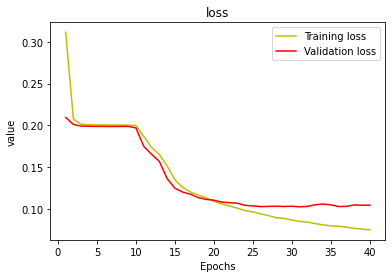

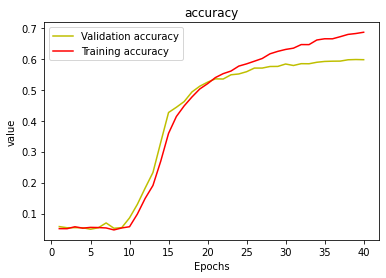

In [30]:
#plotting trainning, validation accuracies and losses
loss = history.history['loss']
loss_val = history.history['val_loss']
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, loss_val, 'r', label='Validation loss')
plt.title('loss')
plt.xlabel('Epochs')
plt.ylabel('value')
plt.legend()
plt.show()

plt.plot(epochs, acc_val, 'y', label='Validation accuracy')
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('accuracy')
plt.xlabel('Epochs')
plt.ylabel('value')
plt.legend()
plt.show()

In [31]:
#calculate the test accuracy
y_pred=np.argmax(classifier.predict(X_test),axis=1) #predict on test data
y_true=np.argmax(y_test_en,axis=1) #true values
acc=sum(y_pred==y_true)/len(y_pred) #calculate the accuracy
print('test accuracy : ',acc)

test accuracy :  0.5665161975570897


## Naive Bayes

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, PredefinedSplit

In [33]:
# combine validation and training sets to do grid search
X_train_val = pd.concat([X_train, X_validation], axis = 0)
X_train_val = X_train_val.reset_index(drop = True)

# y_train_val = pd.concat([y_train, y_validation], axis = 0)
# y_train_val = y_train_val.reset_index(drop = True)

In [34]:
y_train_val = np.concatenate((y_train_en, y_validation_en))
y_train_val  = pd.DataFrame(y_train_val).apply(lambda x: x.argmax(), axis=1).values
y_train_val

array([17, 14, 11, ...,  0,  3, 12])

In [35]:
y_test = pd.DataFrame(y_test_en).apply(lambda x: x.argmax(), axis=1).values

#### grid search 

In [36]:
# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1] * len(X_train) + [0] * len(X_validation)
pds = PredefinedSplit(test_fold = split_index)

gnb_clf = GaussianNB()
parameters = {
    'var_smoothing': [1e-1,1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
}
clf = GridSearchCV(gnb_clf, parameters, cv=pds, verbose=1, n_jobs=1) #it is hold-out validation here
clf.fit(X_train_val, y_train_val)

print('Best parameter:',clf.best_params_) #best performance on training set and its parameter
print('Best train accuracy score:', clf.best_score_)

Fitting 1 folds for each of 15 candidates, totalling 15 fits
Best parameter: {'var_smoothing': 0.01}
Best train accuracy score: 0.4100160685591859


In [37]:
#grid search performance
pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

,var_smoothing,Accuracy
0,1.000000e-01,0.397697
1,1.000000e-02,0.410016
2,1.000000e-03,0.408677
3,1.000000e-04,0.408677
4,1.000000e-05,0.408677
5,1.000000e-06,0.408677
6,1.000000e-07,0.408677
7,1.000000e-08,0.408677
8,1.000000e-09,0.408677
9,1.000000e-10,0.408677


In [38]:
#performance on test set
nb_pred = clf.best_estimator_.predict(X_test)
print('Test accuracy score:', accuracy_score(y_test, nb_pred))

macro_averaged_precision = precision_score(y_test, nb_pred, average = 'macro')
print('Test macro averaged precision score:', macro_averaged_precision)

recall = recall_score(y_test, nb_pred, average = 'macro')
print('Test recall score:', recall)

macro_averaged_f1 = f1_score(y_test, nb_pred, average = 'macro')
print('Test macro averaged f1 score:', macro_averaged_f1)

Test accuracy score: 0.3826340945300053
Test macro averaged precision score: 0.47144326143639104
Test recall score: 0.3736535048518578
Test macro averaged f1 score: 0.3831879246248504


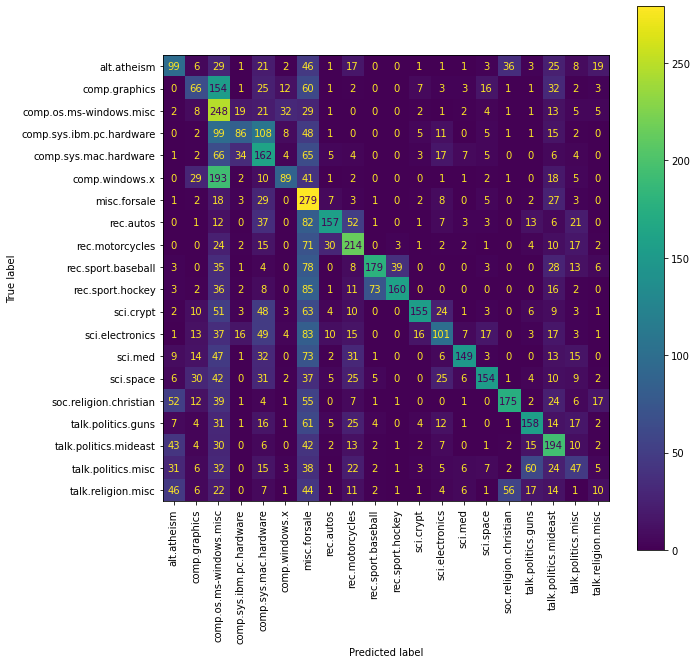

In [39]:
cm = confusion_matrix(y_test, nb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=names)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax)

plt.show()

## KNN

In [40]:
from sklearn.neighbors import KNeighborsClassifier

#### grid search

In [41]:
k_range = list(range(1, 31)) # possible k

param_grid = dict(n_neighbors=k_range)

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, param_grid, cv=pds, verbose=1, n_jobs=1)
  
# fitting the model for grid search
clf =clf.fit(X_train_val, y_train_val)
print('Best parameter:',clf.best_params_) #best performance on training set and its parameter
print('Best train accuracy score:', clf.best_score_)

Fitting 1 folds for each of 30 candidates, totalling 30 fits
Best parameter: {'n_neighbors': 18}
Best train accuracy score: 0.5640064274236744


In [42]:
#grid search performance
pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

,n_neighbors,Accuracy
0,1,0.563203
1,2,0.510177
2,3,0.527049
3,4,0.533208
4,5,0.544456
5,6,0.548206
6,7,0.552223
7,8,0.549813
8,9,0.559186
9,10,0.557847


In [43]:
#performance on test set
knn_pred = clf.best_estimator_.predict(X_test)
print('Test accuracy score:', accuracy_score(y_test, knn_pred))

macro_averaged_precision = precision_score(y_test, knn_pred, average = 'macro')
print('Test macro averaged precision score:', macro_averaged_precision)

recall = recall_score(y_test, knn_pred, average = 'macro')
print('Test recall score:', recall)

macro_averaged_f1 = f1_score(y_test, knn_pred, average = 'macro')
print('Test macro averaged f1 score:', macro_averaged_f1)

Test accuracy score: 0.5108868826340945
Test macro averaged precision score: 0.5488088336532362
Test recall score: 0.4987007387344463
Test macro averaged f1 score: 0.5043855165816253


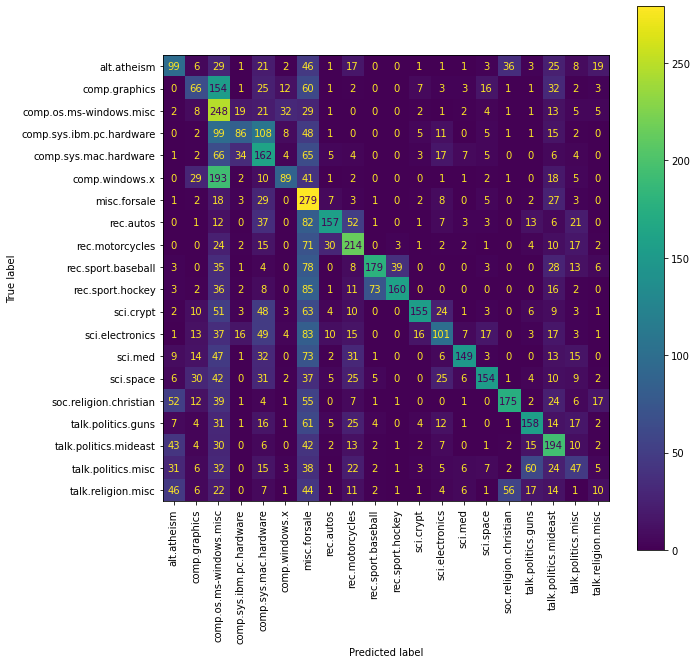

In [44]:
cm = confusion_matrix(y_test, nb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=names)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax)

plt.show()

## 1 dimensional CNN | Conv1D-without using Pre-trained Embedding

In [45]:
#define X and y
X = df_train['texts']
y = df_train['folder name']
X_test=df_test['texts']
y_test=df_test['folder name']

X_train, X_val = train_test_split(X, test_size=0.33, random_state=42) #use the same split seed as that used in knn and nb
y_train, y_val = train_test_split(y, test_size=0.33, random_state=42)

In [46]:
names=np.unique(np.array(y_train)) #getting unique categories
print(names)

['alt.atheism' 'comp.graphics' 'comp.os.ms-windows.misc'
 'comp.sys.ibm.pc.hardware' 'comp.sys.mac.hardware' 'comp.windows.x'
 'misc.forsale' 'rec.autos' 'rec.motorcycles' 'rec.sport.baseball'
 'rec.sport.hockey' 'sci.crypt' 'sci.electronics' 'sci.med' 'sci.space'
 'soc.religion.christian' 'talk.politics.guns' 'talk.politics.mideast'
 'talk.politics.misc' 'talk.religion.misc']


#### Creat Text Vectorization from Training Dataset

In [47]:
# Creating vectorizer and adapting to the training data to be use for all data,restriced to 20,000 vocabulary
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(X_train.values.tolist())
vectorizer.adapt(text_ds)
voc = vectorizer.get_vocabulary()

In [48]:
num_tokens = len(voc) + 2
embedding_dim = 200

#### Prepare Input Data for CNN Model

In [49]:
class_names=y.unique()
label_names=list(class_names)
label_index=(np.unique(label_names, return_inverse=True)[1])
label_code=(np.unique(y, return_inverse=True)[1])

print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(7580,) (3734,)
(7580,) (3734,)


In [50]:
x_train = vectorizer(np.array([[s] for s in X_train.values.tolist()])).numpy()
x_val = vectorizer(np.array([[s] for s in X_val.values.tolist()])).numpy()
x_test = vectorizer(np.array([[s] for s in X_test.values.tolist()])).numpy()

In [51]:
y_train=np.array(np.unique(y_train, return_inverse=True)[1])
y_val=(np.unique(y_val, return_inverse=True)[1])
y_test=(np.unique(y_test, return_inverse=True)[1])

In [52]:
# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(num_tokens, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a multiclass unit output layer, and squash it with a softmax:
predictions = layers.Dense(len(label_names), activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with multiclass crossentropy loss and an rmsprop optimizer.
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
print("Simple Neural Network")
model.summary()

Simple Neural Network
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 200)         4000400   
                                                                 
 dropout_2 (Dropout)         (None, None, 200)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         179328    
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                       

#### Graphical representation of CNN Model

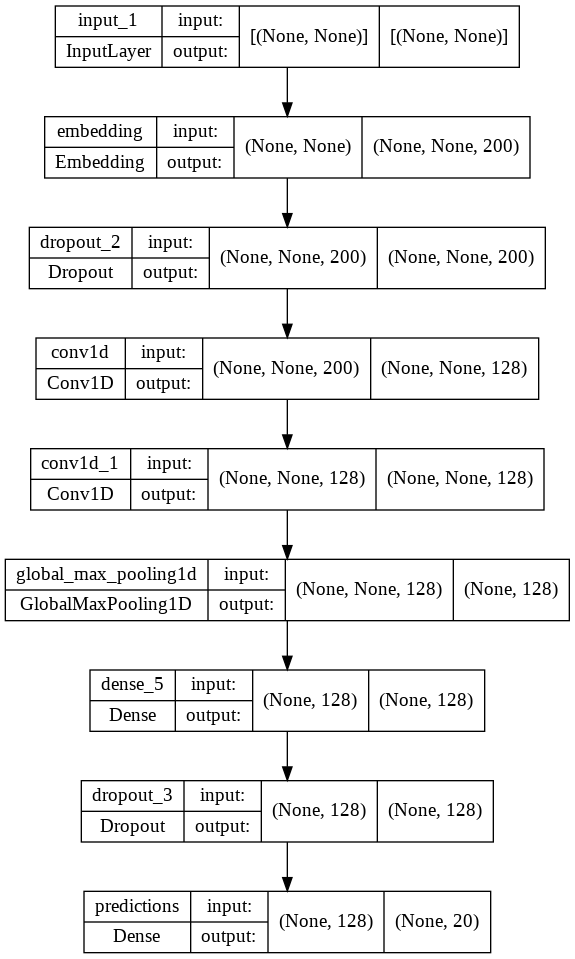

In [53]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

#### Model Training

In [54]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1,
    )
]

In [55]:
epochs = 50
batch_size=64
# Fit the model using the train and test datasets.
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history2=model.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=epochs,batch_size=batch_size,callbacks=callbacks)

Epoch 1/50
119/119 [==============================] - 25s 202ms/step - loss: 2.9705 - accuracy: 0.0670 - val_loss: 2.8862 - val_accuracy: 0.1144
Epoch 2/50
119/119 [==============================] - 26s 221ms/step - loss: 2.6560 - accuracy: 0.1285 - val_loss: 2.3739 - val_accuracy: 0.1741
Epoch 3/50
119/119 [==============================] - 33s 279ms/step - loss: 2.3187 - accuracy: 0.1910 - val_loss: 2.0735 - val_accuracy: 0.2817
Epoch 4/50
119/119 [==============================] - 24s 201ms/step - loss: 1.9284 - accuracy: 0.3115 - val_loss: 1.6707 - val_accuracy: 0.4092
Epoch 5/50
119/119 [==============================] - 24s 200ms/step - loss: 1.4722 - accuracy: 0.4772 - val_loss: 1.3242 - val_accuracy: 0.5779
Epoch 6/50
119/119 [==============================] - 26s 222ms/step - loss: 1.0507 - accuracy: 0.6352 - val_loss: 1.1458 - val_accuracy: 0.6460
Epoch 7/50
119/119 [==============================] - 24s 199ms/step - loss: 0.7289 - accuracy: 0.7541 - val_loss: 0.8547 - val_ac

#### Exhibit Accuracy and Validation Loss of CNN Model

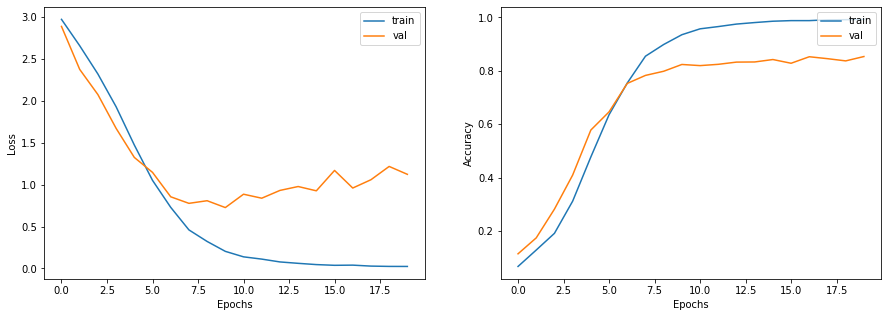

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history2.history["loss"])
ax1.plot(history2.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history2.history["accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

#### Performance of CNN Model on Test Set

In [57]:
_, test_accuracy = model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 74.64%


In [58]:
cnn_pred = model.predict(x_test)
cnn_pred = pd.DataFrame(cnn_pred).apply(lambda x: x.argmax(), axis=1).values

In [59]:
macro_averaged_precision = precision_score(y_test, cnn_pred, average = 'macro')
print('Test macro averaged precision score:', macro_averaged_precision)

recall = recall_score(y_test, cnn_pred, average = 'macro')
print('Test recall score:', recall)

macro_averaged_f1 = f1_score(y_test, cnn_pred, average = 'macro')
print('Test macro averaged f1 score:', macro_averaged_f1)

Test macro averaged precision score: 0.7520570712350769
Test recall score: 0.7431498661045258
Test macro averaged f1 score: 0.7428446876872137


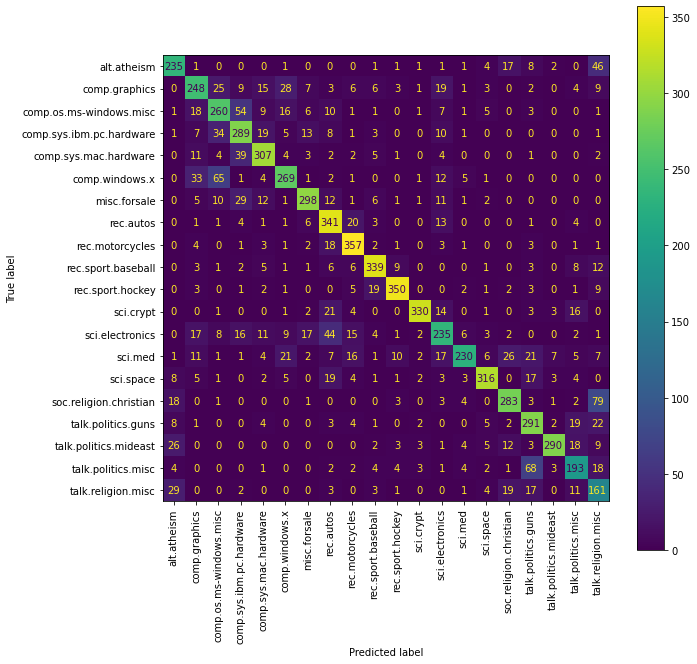

In [60]:
cm = confusion_matrix(y_test, cnn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=names)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax)

plt.show()

# Convert to vectors using word2vec

In [61]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
import tensorflow as tf
from tensorflow import keras
from keras import initializers
%matplotlib inline
from sklearn.model_selection import StratifiedShuffleSplit

# Creating Training,Validation and Testing Variables/Data

In [62]:
#Shuffling Data for Splitting Randomly
seed=1337
rng = np.random.RandomState(seed)
rng.shuffle(df_train.texts.values.tolist())
rng = np.random.RandomState(seed)
rng.shuffle(np.unique(df_train['folder name'].values.tolist()))


In [63]:
#Extracted the Required Data.
X = df_train['texts']
y = df_train['folder name']
X_test=df_test['texts']
y_test=df_test['folder name']


In [64]:
#Splitting the shuffled Training data into Training and Validation set
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
sss.get_n_splits(X, y)
print(sss)
for train_index, val_index in sss.split(X, y):
  print("train_index:", train_index, "val_index:", val_index)
  X_train, X_val = X[train_index], X[val_index]
  Y_train, Y_val = y[train_index], y[val_index]
  

StratifiedShuffleSplit(n_splits=2, random_state=0, test_size=0.2,
            train_size=None)
train_index: [8150 9617 3240 ... 5761  524 1319] val_index: [ 3740    66   942 ... 11267  3465 10264]
train_index: [2946 1610  659 ... 5364 9236 1490] val_index: [5413 2330 7765 ... 4490 5774 6328]


In [65]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# **Creating Text Vectorization from Training Dataset**

In [66]:
#Creating vectorizer and adapting to the training data to be use for all data,restriced to 20,000 vocabulary
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(X_train.values.tolist())
vectorizer.adapt(text_ds)

In [67]:
#testing vectorizer
vectorizer.get_vocabulary()[0:5]

['', '[UNK]', 'the', 'to', 'of']

In [68]:
#Creating word_index mapping to the vocabulary created from the vectorizer
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [69]:
#Testing word_index
test = ["cat", "sat", "mat"]
[word_index[w] for w in test]

[3494, 2923, 6107]

### Get Embeddings-Using GLOVE word2vec
GloVe is an unsupervised learning algorithm for obtaining vector representations for words

In [70]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-04-21 02:03:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-21 02:03:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-21 02:03:01--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

# **Training the Embedding**

In [71]:
embeddings_index = {}
f = open('/content/glove.6B.100d.txt',encoding='utf8')# source of the downloaded glove files-use the 100d.txt
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [72]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0
embedding_matrix = np.random.random((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 17409 words (2591 misses)


# **PreTrained Embedding**

In [73]:
embedding_layer = Embedding(
num_tokens,
embedding_dim,
embeddings_initializer=keras.initializers.Constant(embedding_matrix),
trainable=False,)
embedding_layer

## **Preparing Data input for Models**

In [74]:
class_names=y.unique()
label_names=list(class_names)
label_index=(np.unique(label_names, return_inverse=True)[1])
label_code=(np.unique(y, return_inverse=True)[1])

In [75]:
print(X_train.shape, X_val.shape)
print(Y_train.shape, Y_val.shape)

(9051,) (2263,)
(9051,) (2263,)


In [76]:
x_train = vectorizer(np.array([[s] for s in X_train.values.tolist()])).numpy()
x_val = vectorizer(np.array([[s] for s in X_val.values.tolist()])).numpy()
x_test = vectorizer(np.array([[s] for s in X_test.values.tolist()])).numpy()
type(x_test)

numpy.ndarray

In [77]:
y_train=np.array(np.unique(Y_train, return_inverse=True)[1])
y_val=(np.unique(Y_val, return_inverse=True)[1])
y_test=(np.unique(y_test, return_inverse=True)[1])

# **1 dimensional CNN | Conv1D Maxpooling and GlobalMax Pooling Using PreTrained Embedding**

In [78]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(label_names), activation="softmax")(x)
model1 = keras.Model(int_sequences_input, preds)
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         2000200   
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 128)        0         
 1D)                                                       

# **Graphical represention of Model1**

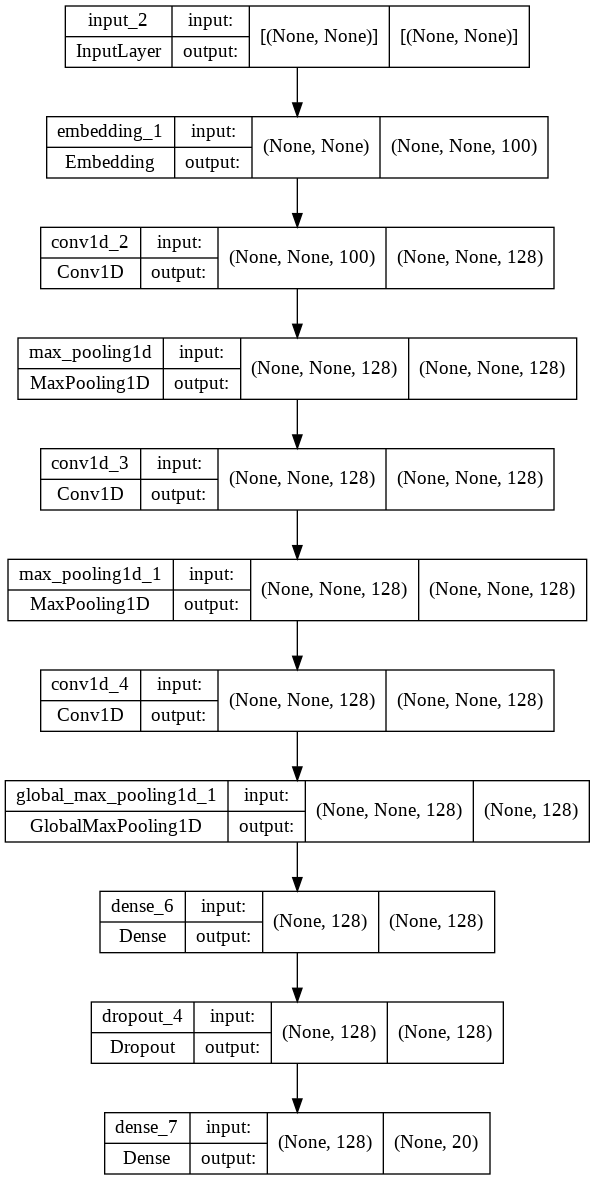

In [79]:
keras.utils.plot_model(model1, "multi_input_and_output_model.png", show_shapes=True)

# **Training Model1**

In [80]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=10,
        verbose=1,
    )
]

In [81]:
epochs = 50
batch_size=64
model1.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
cp=ModelCheckpoint('model_1.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history1=model1.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val),batch_size=batch_size,callbacks=callbacks)

Epoch 1/50
142/142 [==============================] - 18s 116ms/step - loss: 2.7426 - acc: 0.1248 - val_loss: 2.3143 - val_acc: 0.1927
Epoch 2/50
142/142 [==============================] - 16s 114ms/step - loss: 2.0604 - acc: 0.2844 - val_loss: 1.6051 - val_acc: 0.4450
Epoch 3/50
142/142 [==============================] - 16s 113ms/step - loss: 1.4974 - acc: 0.4819 - val_loss: 1.3416 - val_acc: 0.5493
Epoch 4/50
142/142 [==============================] - 16s 113ms/step - loss: 1.1430 - acc: 0.5951 - val_loss: 1.2946 - val_acc: 0.5824
Epoch 5/50
142/142 [==============================] - 16s 113ms/step - loss: 0.8963 - acc: 0.6875 - val_loss: 0.9169 - val_acc: 0.7000
Epoch 6/50
142/142 [==============================] - 16s 113ms/step - loss: 0.7143 - acc: 0.7515 - val_loss: 0.9397 - val_acc: 0.7039
Epoch 7/50
142/142 [==============================] - 16s 113ms/step - loss: 0.5730 - acc: 0.8028 - val_loss: 0.9405 - val_acc: 0.6894
Epoch 8/50
142/142 [==============================] - 1

# **Plotting the Accuracy and validation Loss for model1**

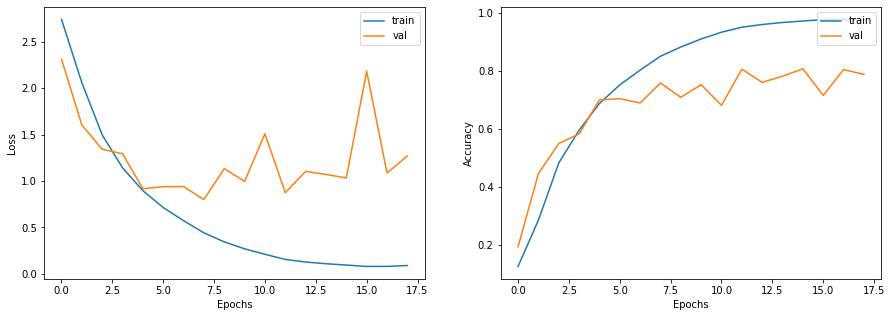

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history1.history["loss"])
ax1.plot(history1.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history1.history["acc"])
ax2.plot(history1.history["val_acc"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

# **Testing Model1 with testing dataset**

In [83]:
_, test_accuracy = model1.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 71.42%


# **Predicting using unknow raw text-Model1**

In [84]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model1(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict([['Update and Re-fit a Model Call Description. update will update and (by default) re-fit a model']])

class_names[np.argmax(probabilities[0])]

'rec.sport.hockey'

## **1 dimensional CNN | Conv1D-without using Pre-trained Embedding**

In [85]:
import tensorflow as tf

In [86]:
from tensorflow.keras import layers

# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(num_tokens, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a multiclass unit output layer, and squash it with a softmax:
predictions = layers.Dense(len(label_names), activation="softmax", name="predictions")(x)

model2 = tf.keras.Model(inputs, predictions)

# Compile the model with multiclass crossentropy loss and an rmsprop optimizer.
model2.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
print("Simple Neural Network")
model2.summary()

Simple Neural Network
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 100)         2000200   
                                                                 
 dropout_5 (Dropout)         (None, None, 100)         0         
                                                                 
 conv1d_5 (Conv1D)           (None, None, 128)         89728     
                                                                 
 conv1d_6 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                     

# **Graphical representation of Model2**


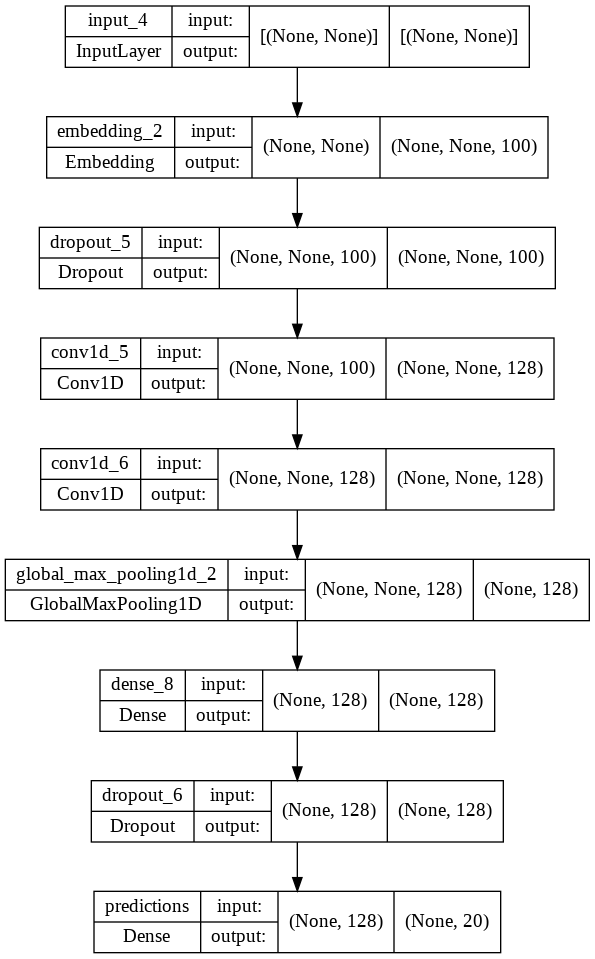

In [87]:
keras.utils.plot_model(model2, "multi_input_and_output_model.png", show_shapes=True)

# **Training of Model2**

In [88]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1,
    )
]

In [89]:
epochs = 50
batch_size=64
# Fit the model using the train and test datasets.
cp=ModelCheckpoint('model_1.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history2=model2.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=epochs,batch_size=batch_size,callbacks=callbacks)

Epoch 1/50
142/142 [==============================] - 19s 126ms/step - loss: 2.9661 - accuracy: 0.0675 - val_loss: 2.8215 - val_accuracy: 0.0977
Epoch 2/50
142/142 [==============================] - 18s 125ms/step - loss: 2.6077 - accuracy: 0.1239 - val_loss: 2.3739 - val_accuracy: 0.1542
Epoch 3/50
142/142 [==============================] - 18s 125ms/step - loss: 2.2894 - accuracy: 0.1822 - val_loss: 2.0772 - val_accuracy: 0.2616
Epoch 4/50
142/142 [==============================] - 18s 125ms/step - loss: 1.9430 - accuracy: 0.2913 - val_loss: 1.6946 - val_accuracy: 0.4384
Epoch 5/50
142/142 [==============================] - 18s 124ms/step - loss: 1.4905 - accuracy: 0.4615 - val_loss: 1.2660 - val_accuracy: 0.5833
Epoch 6/50
142/142 [==============================] - 18s 125ms/step - loss: 1.0274 - accuracy: 0.6278 - val_loss: 0.9914 - val_accuracy: 0.6686
Epoch 7/50
142/142 [==============================] - 18s 125ms/step - loss: 0.7385 - accuracy: 0.7372 - val_loss: 0.8437 - val_ac

# **Plotting Accuracy and validation loss of Model2**

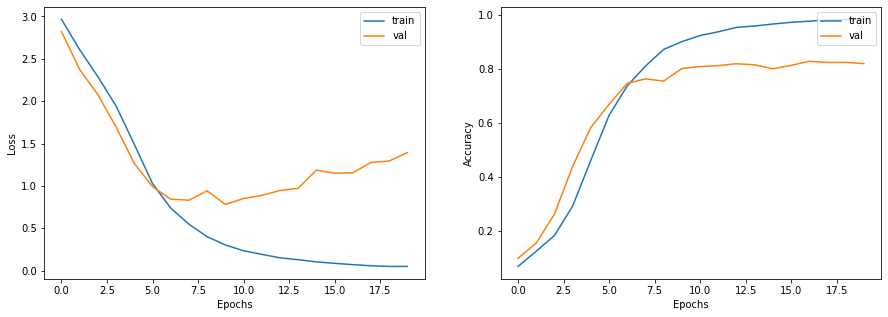

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history2.history["loss"])
ax1.plot(history2.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history2.history["accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

# **Testing Model2 with Test dataset**

In [91]:
_, test_accuracy = model2.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 72.69%


# **Predicting unknown text with Model2**

In [92]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model2(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    [['As a sanity check, if the embedding matrix has been generated properly. In the above, when I saw the first five entries of\nthe training set, the first entry was\n']]
)

class_names[np.argmax(probabilities[0])]
#df_train.texts[500]

'rec.sport.hockey'

# **RNN-Bidirectional LSTM Model 50 Unit**

In [93]:
sequence_input = Input(shape=(200,), dtype='int64')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(50))(embedded_sequences)
preds = Dense(len(label_names), activation='softmax')(l_lstm)
model3 = Model(sequence_input, preds)
model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print("Bidirectional LSTM")
model3.summary()

Bidirectional LSTM
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     multiple                  2000200   
                                                                 
 bidirectional (Bidirectiona  (None, 100)              60400     
 l)                                                              
                                                                 
 dense_9 (Dense)             (None, 20)                2020      
                                                                 
Total params: 2,062,620
Trainable params: 62,420
Non-trainable params: 2,000,200
_________________________________________________________________


# **Graphical representation of model3**

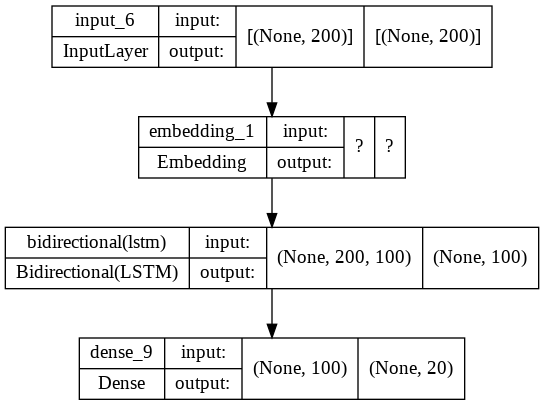

In [94]:
keras.utils.plot_model(model3, "multi_input_and_output_model.png", show_shapes=True)

# **Training Model3**

In [95]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1,
    )
]

In [96]:
epochs=30
batch_size=20
cp=ModelCheckpoint('model_1.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history3=model3.fit(x_train, y_train, validation_data=(x_val,y_val),epochs=epochs, batch_size=batch_size,callbacks=callbacks)

Epoch 1/30
453/453 [==============================] - 61s 127ms/step - loss: 2.4161 - acc: 0.2205 - val_loss: 2.0837 - val_acc: 0.3014
Epoch 2/30
453/453 [==============================] - 57s 125ms/step - loss: 1.6667 - acc: 0.4380 - val_loss: 1.4229 - val_acc: 0.5117
Epoch 3/30
453/453 [==============================] - 57s 126ms/step - loss: 1.2354 - acc: 0.5810 - val_loss: 1.1656 - val_acc: 0.6178
Epoch 4/30
453/453 [==============================] - 57s 126ms/step - loss: 1.0016 - acc: 0.6653 - val_loss: 1.0567 - val_acc: 0.6558
Epoch 5/30
453/453 [==============================] - 57s 126ms/step - loss: 0.8419 - acc: 0.7272 - val_loss: 0.9218 - val_acc: 0.6894
Epoch 6/30
453/453 [==============================] - 57s 126ms/step - loss: 0.7222 - acc: 0.7653 - val_loss: 0.8453 - val_acc: 0.7357
Epoch 7/30
453/453 [==============================] - 57s 126ms/step - loss: 0.6284 - acc: 0.7995 - val_loss: 0.7834 - val_acc: 0.7464
Epoch 8/30
453/453 [==============================] - 5

## **Plotting accuracy and loss of Model3**

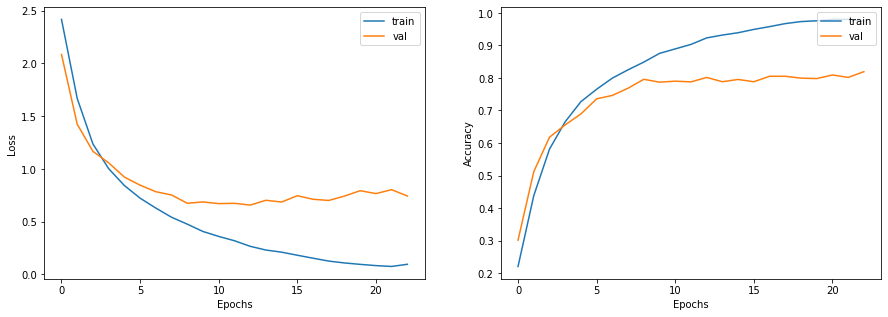

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history3.history["loss"])
ax1.plot(history3.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history3.history["acc"])
ax2.plot(history3.history["val_acc"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

# **Testing Model3 on Testing data**

In [98]:
_, test_accuracy = model3.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 73.17%


# **Predicting with Model3**

In [99]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model3(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    [['Jon playes cricket His favourite player is MS DhoniSometimes he loves to play football']]
)

class_names[np.argmax(probabilities[0])]

'rec.sport.baseball'

# **1 dimensional CNN MODEL- Developed as a function**

In [100]:
def ConvNet1(embeddings, num_tokens, embedding_dim, label_code):
    
    embedding_layer = Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,)
    
    sequence_input = Input(shape=(None,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
    x = layers.MaxPooling1D(5)(x)
    x = layers.Conv1D(128, 5, activation="relu")(x)
    x = layers.MaxPooling1D(5)(x)
    x = layers.Conv1D(128, 5, activation="relu")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    preds = Dense(len(label_names), activation='softmax')(x)
    model = keras.Model(sequence_input, preds)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer="adam",
                  metrics=['acc'])
    model.summary()
    return model

In [101]:
model4 = ConvNet1(embedding_matrix, num_tokens,embedding_dim,label_code)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         2000200   
                                                                 
 conv1d_7 (Conv1D)           (None, None, 128)         64128     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 128)        0         
 1D)                                                       

# **Graph of Model4**

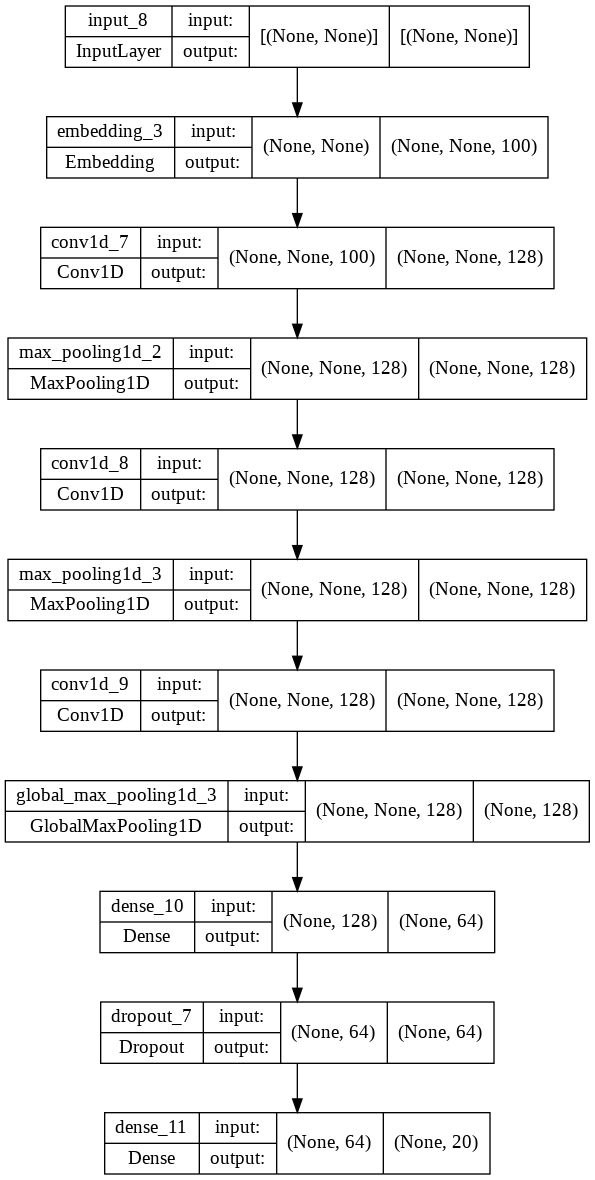

In [102]:
keras.utils.plot_model(model4, "multi_input_and_output_model.png", show_shapes=True)

# **Training of Model4**

In [103]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1,
    )
]

In [104]:
epochs=50
batch_size=64
cp=ModelCheckpoint('model_1.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

In [105]:
model4 = ConvNet1(embedding_matrix, num_tokens, embedding_dim,label_code)
history4 = model4.fit(x_train, y_train, epochs=epochs, shuffle=True,validation_data=(x_val,y_val), batch_size=batch_size,callbacks=callbacks)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 100)         2000200   
                                                                 
 conv1d_10 (Conv1D)          (None, None, 128)         64128     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, None, 128)         82048     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, None, 128)        0         
 1D)                                                       

## **Plotting accuracy and loss of Model4**

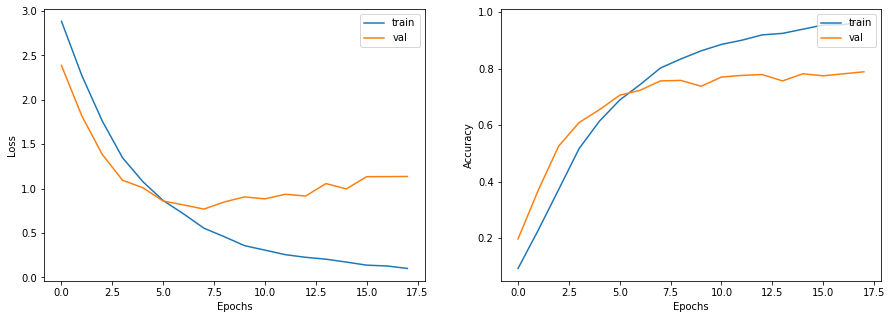

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history4.history["loss"])
ax1.plot(history4.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history4.history["acc"])
ax2.plot(history4.history["val_acc"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

## **Testing Model4**

In [107]:
_, test_accuracy = model4.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 72.08%


# **Predicting with Model4**

In [108]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model4(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    [["Jon playes cricket His favourite player is MS Dhoni Sometimes he loves to play football"]]
)

class_names[np.argmax(probabilities[0])]

'rec.sport.baseball'